In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd
import exoplanet as xo

from flareTools import FINDflare, IRLSSpline

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

CPA with rolling median subtraction seems to be detecting a lot of flares right at the gap in the lightcurves. Lets see why this is happening.

In [2]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

f1 = 'tess2019006130736-s0007-0000000293972244-0131-s_lc.fits' # Rolling median subtraction finds a flare, spline subtraction does not

Text(0, 0.5, 'Flux [e-/s]')

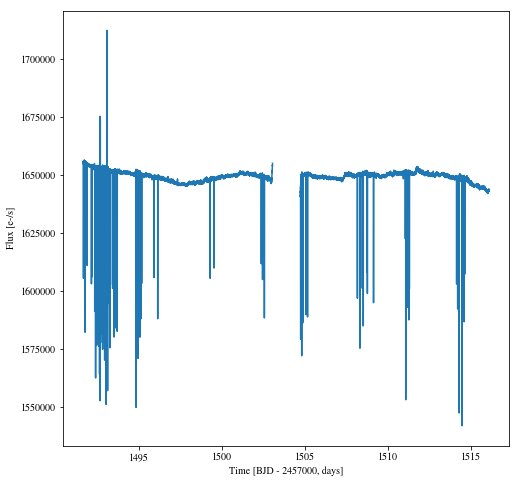

In [3]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [4]:
# Throw out NaN fluxes and do a quality cut
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

In [5]:
ok_cut = quality == 0

median = np.nanmedian(flux[ok_cut])
acf = xo.autocorr_estimator(time[ok_cut], flux[ok_cut]/median,
                            yerr=error[ok_cut]/median,
                            min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    s_window = 128

print(s_window)
    
smo = pd.DataFrame(flux[ok_cut]).rolling(s_window, center=True).median().values
smo = smo.reshape(1, -1)[0]

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux[ok_cut][sok_cut]-smo[sok_cut])/median, 
                              error[ok_cut][sok_cut]/median, avg_std=False, N1=4, N2=2, N3=5)

1038


Notice that the rolling median is undefined at the beginning and end of the light curve

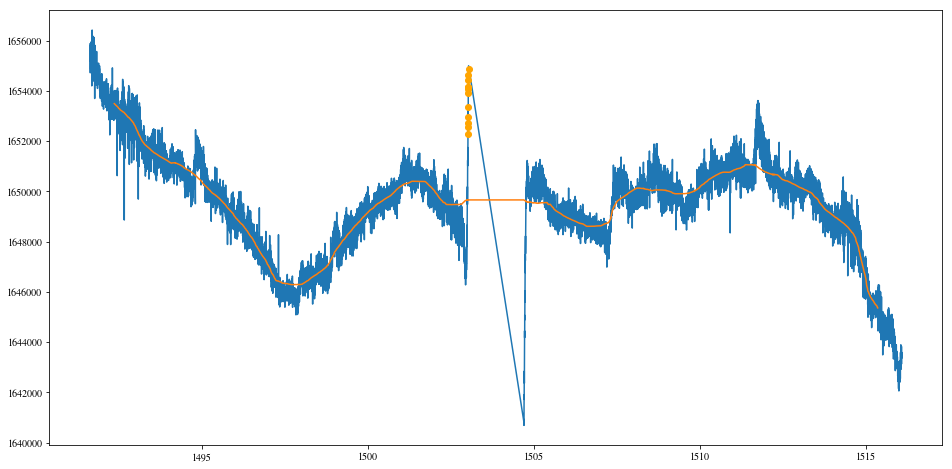

In [10]:
fig, axes = plt.subplots(figsize=(16,8))
axes.plot(time[ok_cut], flux[ok_cut])
axes.plot(time[ok_cut][sok_cut], smo[sok_cut])

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 
              flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)